In [2]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'

--2021-10-28 22:32:28--  https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘mini_classes.txt’

mini_classes.txt    100%[===================>]     760  --.-KB/s    in 0s      

2021-10-28 22:32:28 (13.9 MB/s) - ‘mini_classes.txt’ saved [760/760]



In [3]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [4]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [6]:
import urllib.request

def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [7]:
!mkdir data
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

In [8]:
import os
import glob
import numpy as np
from tensorflow.keras.layers import Convolution2D, MaxPool2D, Flatten, Dense
from tensorflow import keras 
import tensorflow as tf

In [9]:
def load_data(root, vfold_ratio=0.05, max_items_per_class= 7500):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load a subset of the data to memory 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None

    #separate into training and testing 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    
    return x_train, y_train, x_test, y_test, class_names

In [10]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

ValueError: ignored

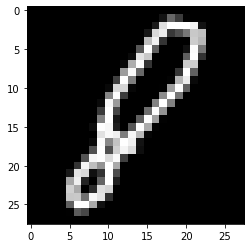

In [25]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

In [11]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [12]:
# Define model
model = keras.Sequential([
    Convolution2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:], activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(64, (3, 3), padding='same', activation= 'relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(128, (3, 3), padding='same', activation= 'relu'),
    MaxPooling2D(pool_size =(2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(100, activation='softmax'),
])

# Train model
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['top_k_categorical_accuracy']
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

In [19]:
#fit the model 
model.fit(
    x = x_train,
    y = y_train,
    validation_split=0.1,
    batch_size = 256,
    verbose=1,
    epochs=30
)

Epoch 1/10
1670/1670 [==============================] - 21s 12ms/step - loss: 0.7315 - top_k_categorical_accuracy: 0.9445 - val_loss: 0.8190 - val_top_k_categorical_accuracy: 0.9358
Epoch 2/10
1670/1670 [==============================] - 20s 12ms/step - loss: 0.7193 - top_k_categorical_accuracy: 0.9460 - val_loss: 0.8143 - val_top_k_categorical_accuracy: 0.9361
Epoch 3/10
1670/1670 [==============================] - 20s 12ms/step - loss: 0.7077 - top_k_categorical_accuracy: 0.9468 - val_loss: 0.8225 - val_top_k_categorical_accuracy: 0.9371
Epoch 4/10
1670/1670 [==============================] - 20s 12ms/step - loss: 0.6972 - top_k_categorical_accuracy: 0.9477 - val_loss: 0.8171 - val_top_k_categorical_accuracy: 0.9363
Epoch 5/10
1670/1670 [==============================] - 20s 12ms/step - loss: 0.6883 - top_k_categorical_accuracy: 0.9486 - val_loss: 0.8273 - val_top_k_categorical_accuracy: 0.9369
Epoch 6/10
1670/1670 [==============================] - 20s 12ms/step - loss: 0.6797 - top

In [14]:
#evaluate on unseen data
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuarcy: {score[1] * 100:0.2f}%')

Test accuarcy: 93.49%


['t-shirt', 'bread', 'tree', 'hammer', 'drums']


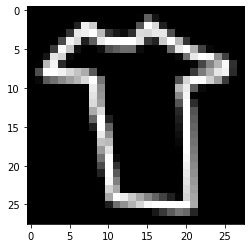

In [29]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

In [20]:
!mkdir model
model.save('model/keras.h5')
with open('model/class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))
!zip -r model.zip model 

In [21]:
from google.colab import files
files.download('model.zip')